# Likelihood
This document explains the likelihood function for our data, as a function of a phase shift applied to the source signal.

In [75]:
import matplotlib.pyplot as plt
import numpy as np
#from scipy.fftpack import *
import scipy.optimize
import itertools
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

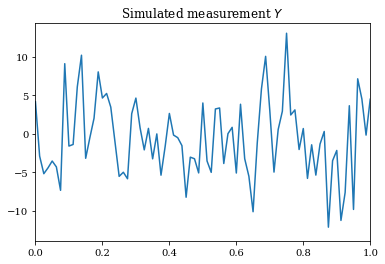

In [94]:
sampleFreq = 80
Tmax = 2

N = int(Tmax*sampleFreq)
T = np.array([float(i)/sampleFreq for i in range(N)])
Tmax = float(N)/sampleFreq

#sourceFreqs = [4.77, 6.123, 20.1]
sourceFreqs = (4.77,16.123)
n = len(sourceFreqs)

def sourceFunc(t, sourcePhases):
    if len(sourceFreqs) != len(sourcePhases):
        raise ValueError('Number of source frequencies does not number of source phases')
    return sum(np.sin((t * freq + phase)*2.0*np.pi) for freq,phase in zip(sourceFreqs,sourcePhases))





## Let's simulate a measurement by delaying the signal, adding noise and superimposing a second sinusoid.
# Signal delay in seconds
#actualPhaseShifts = (.5,.2)
actualPhaseShifts = tuple(np.random.uniform(size=n))
noiseSTD = 5

#Y = np.interp(T[:N-delayIndex] + delay, T, X)
#Y = Xfunc(T[:N] + delay)

Y = sourceFunc(T, actualPhaseShifts)

noise = np.random.normal(size=Y.shape, loc=0, scale=noiseSTD)
Y+= noise


if len(sourceFreqs) == 1:
    plt.subplot(1,2,1)
    plt.title("Original signal $X$")
    plt.xlim(0,1)
    plt.plot(T,sourceFunc(T, (0,)))
    plt.subplot(1,2,2)
plt.title("Simulated measurement $Y$")
plt.xlim(0,1)
plt.plot(T[:N],Y)

plt.show()

## Method 2
If we model the noise as a normal distribution, independent for each measurement point, we have:

$Y(t) \sim N(X(t,\phi_1,\dots,\phi_n), \sigma^2)$

where $\phi_i$ phase shift of the $i$th wave, to be learned from data.

Since the time domain is discretized, the likelihood function for a measurement $Y$ is given by:

$L(\phi_1,\dots,\phi_n) = \prod_{i=0}^{M-1} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(\frac{(Y_i - X(i\cdot f_S,\phi_1,\dots,\phi_n))^2}{2 \sigma^2}\right)$

which gives us the log likelihood function:

$\log L(\phi_1,\dots,\phi_n) = -M \log (\sqrt{2 \pi \sigma^2}) - \frac{1}{2 \sigma^2} \sum_{i=0}^{M-1} (Y_i - X(i\cdot f_S,\phi_1,\dots,\phi_n))^2$

where $f_S$ is the sample rate of our measurement. $M$ is the correlation window.

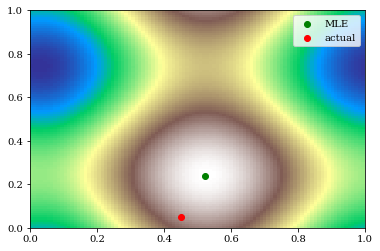

coarse MLE for phase shifts:  (0.5252525252525253, 0.24242424242424243)
fine MLE for phase shifts:  (0.5227061080636078, 0.23994040828558977)
actual phase shifts:  (0.4499831935606762, 0.05096603046004733)


In [95]:
maxShift = min(N,int(sampleFreq / max(sourceFreqs)))
correlationWindow = N - maxShift
M = correlationWindow

noiseVar = noiseSTD**2

def logLikelihood(phaseShifts):
    diffs = Y[:M] - sourceFunc(T[:M], phaseShifts)
    return -M*np.log(np.sqrt(2.0*np.pi*noiseVar)) - np.dot(diffs,diffs) / (2.0 * noiseVar)
    #return -np.dot(diffs,diffs) / (2.0 * noiseVar)
"""
# The correlation window should be as large as possible

def logLikelihood(T_D,interpolate=True):
    M = len(Y)-int(T_D * sampleFreq)-1
    if interpolate:
        diffs = Y[:M] - np.interp(T[:M] + T_D, T, X)
    else:
        D = int(T_D * sampleFreq)
        diffs = Y[:M]-X[D:M + D]
    return -???M*np.log(np.sqrt(2.0*np.pi*noiseVar)) - np.dot(diffs,diffs) / (2.0 * noiseVar)
    return -np.dot(diffs,diffs) / (2.0 * noiseVar)


"""

resolution = 100
phaseShiftGrid = list(itertools.product(list(np.linspace(0,1,num=resolution)), repeat=n))

# Compute the log likelihood function for poissible shift times, given our data:
# TODO: parallelelize
dataLogLikelihood = [logLikelihood(shifts) for shifts in phaseShiftGrid]
# Since the likelihood function is not normalized, we can translate the array to avoid taking the exp of extremely low floating point numbers.
dataLogLikelihood -= np.max(dataLogLikelihood)
dataLikelihood = np.exp(dataLogLikelihood)

# A coarse estimate
MLEcoarse = phaseShiftGrid[np.argmax(dataLikelihood)]
# A finer estimate
MLE = scipy.optimize.minimize(lambda d: -logLikelihood(d), MLEcoarse, bounds=tuple(itertools.repeat((0.0,1.0),n))).x
MLE = tuple(MLE)

if len(sourceFreqs) == 1:
    plt.title("log likelihood for phase shift")
    plt.plot(phaseShiftGrid, dataLogLikelihood,'-')
    plt.axvline(x=actualPhaseShifts[0], color='r',linestyle="dashed",label="actual")
    plt.axvline(x=MLE[0], color='g',label="fine MLE")
    plt.legend()
    plt.show()

    phaseShiftGridPrecise = [(z,) for z in np.linspace(MLE[0] - .1, MLE[0] + .1, num=100)]
    dataLogLikelihoodPrecise = [logLikelihood(shifts) for shifts in phaseShiftGridPrecise]
    dataLogLikelihoodPrecise -= np.max(dataLogLikelihoodPrecise)
    dataLikelihoodPrecise = np.exp(dataLogLikelihoodPrecise)

    plt.title("likelihood for phase shift")
    plt.xlim(MLE[0] - .1, MLE[0] + .1)
    plt.ylim(0,1)
    plt.plot(phaseShiftGrid, dataLikelihood,'b.',label="integer shifts")
    plt.plot(phaseShiftGridPrecise, dataLikelihoodPrecise,'y-',label="precise shifts")
    plt.axvline(x=actualPhaseShifts[0], color='r',linestyle="dashed",label="actual")
    plt.axvline(x=MLE[0], color='g',label="fine MLE")
    plt.legend()
    plt.show()
elif len(sourceFreqs)==2:
    xAxis = np.linspace(0,1,num=resolution)
    yAxis = np.linspace(0,1,num=resolution)
    colorData = np.zeros((resolution,resolution))
    for i,c in enumerate(dataLogLikelihood):
        colorData[i%resolution, i//resolution] = c
    plt.pcolormesh(xAxis,yAxis,colorData, cmap=plt.get_cmap('terrain'))
    plt.scatter(*MLE,color='g',label='MLE')
    plt.scatter(*actualPhaseShifts,color='r',label='actual')
    plt.legend()
    plt.show()

print("coarse MLE for phase shifts: ",MLEcoarse)
print("fine MLE for phase shifts: ",MLE)
print("actual phase shifts: ",actualPhaseShifts)


# Discussion
- Phase shifts close to $0$ do not give accurate results.
- In the likelihood plot, the graphs for integer shifts and precise shift are not scaled by the same factor.
- Method 2 handles a superimposed second signal well, but the result is overly optimistic. For a superposition of $N$ different sinusoid waves, a single likelihood function (as a function of $N$ phase shifts) might give better results, rather than analyzing band-passed signals.
- The assumption that the noise of each measurement point is independently distributed, is probably incorrect.